In [ ]:
# Data Source: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

In [ ]:
# Import necessary libraries
import os
from skimage.feature import local_binary_pattern
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import prewitt_h, prewitt_v
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from yellowbrick.cluster import KElbowVisualizer

## **1. Setup and Data Loading**

In [ ]:
# Directory containing the images
image_dir = 'dataset/images'  # Directory where downloaded images are stored
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

In [ ]:
# Dataframe to hold image categories and names
image_categories = {
    'Category': [],
    'Image_Name': []
}
category_files = {1: [], 2: [], 3: [], 4: []}

In [ ]:
# Assign categories based on filenames
for image in image_files:
  if 'train' in image:
    category = 1 #cloudy
  elif 'desert' in image:
    category = 2 #desert
  elif 'Forest' in image:
    category = 3 #green_area
  elif 'SeaLake' in image:
    category = 4 #water
  category_files[category].append(image)

In [ ]:
# Iterate over each category and its associated files
for category, files in category_files.items():
    # Calculate one fourth the size of the list of files for each category
    one_fourth_size = len(files) // 4
    # Select only one fourth of the files
    limited_files = files[:one_fourth_size]
    # Extend the category list in the dataframe with the category ID
    image_categories['Category'].extend([category] * one_fourth_size)
    # Extend the image name list in the dataframe with the names of the selected files
    image_categories['Image_Name'].extend(limited_files)

In [ ]:
# Create dataframe
df = pd.DataFrame(image_categories)
df

,Category,Image_Name
0,1,train_8013.jpg
1,1,train_27788.jpg
2,1,train_534.jpg
3,1,train_4723.jpg
4,1,train_28242.jpg
...,...,...
1416,4,SeaLake_912.jpg
1417,4,SeaLake_779.jpg
1418,4,SeaLake_681.jpg
1419,4,SeaLake_842.jpg


## **2. Data Visualization**

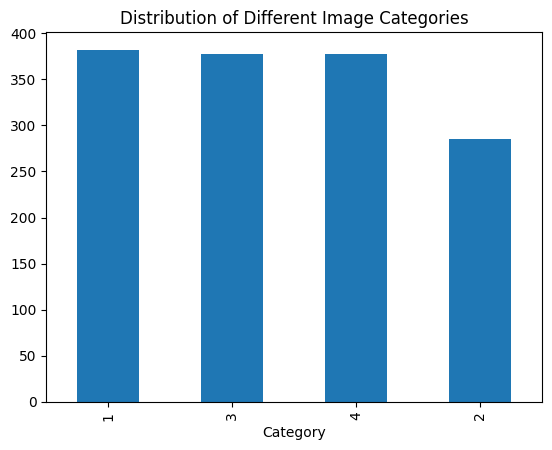

In [ ]:
# Plotting the distribution of different image categories
df['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Different Image Categories')
plt.show()

Image Name: train_8013.jpg
Image Path: /content/drive/MyDrive/Colab Notebooks/CIS9660/Project2-B/Image/train_8013.jpg
Image Shape: (256, 256, 3)


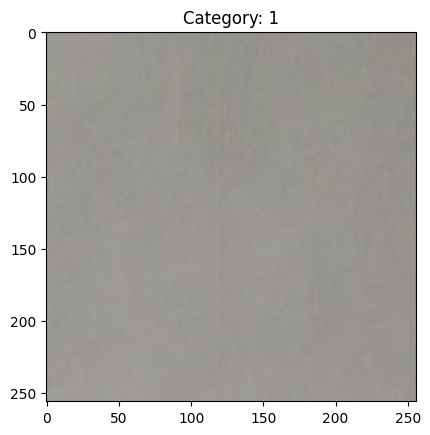

Image Name: desert(786).jpg
Image Path: /content/drive/MyDrive/Colab Notebooks/CIS9660/Project2-B/Image/desert(786).jpg
Image Shape: (256, 256, 3)


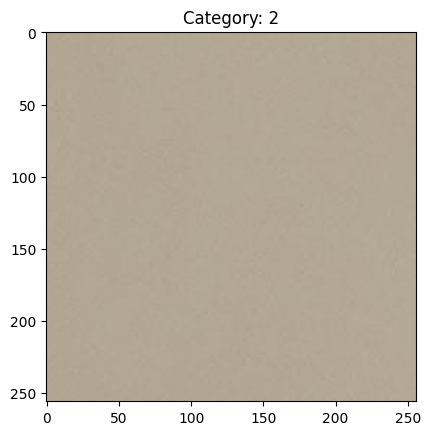

Image Name: Forest_933.jpg
Image Path: /content/drive/MyDrive/Colab Notebooks/CIS9660/Project2-B/Image/Forest_933.jpg
Image Shape: (64, 64, 3)


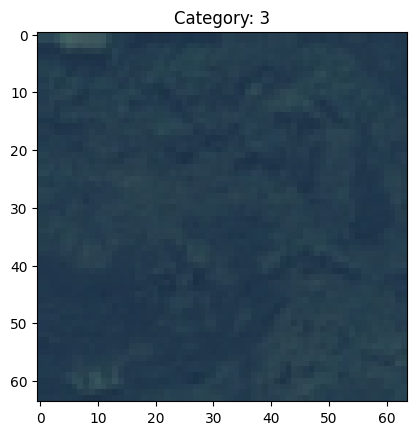

Image Name: SeaLake_2659.jpg
Image Path: /content/drive/MyDrive/Colab Notebooks/CIS9660/Project2-B/Image/SeaLake_2659.jpg
Image Shape: (64, 64, 3)


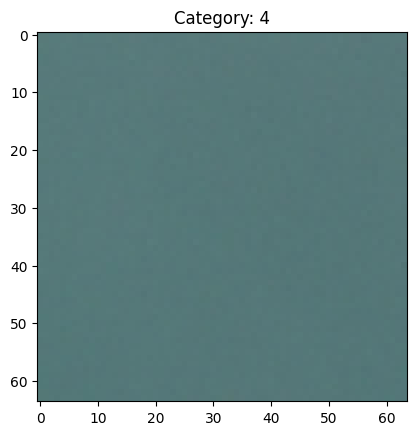

In [ ]:
# Display sample images from each cateogry
for cat in sorted(df['Category'].unique()):
    # Get the name of the first image in the category
    sample_image = df[df['Category'] == cat].iloc[0]['Image_Name']

    # Construct the path to the image file
    image_path = os.path.join(image_dir, sample_image)
    image = imread(image_path)

    # Print details about the image
    print(f'Image Name: {sample_image}')
    print(f'Image Path: {image_path}')
    print(f'Image Shape: {image.shape}')

    # Display the image
    plt.imshow(image)
    plt.title(f'Category: {cat}')
    plt.show()

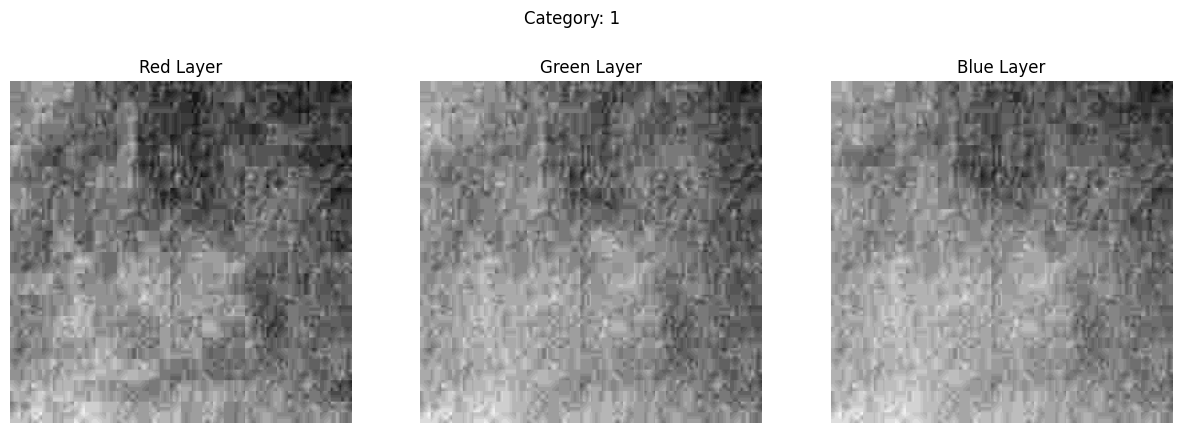

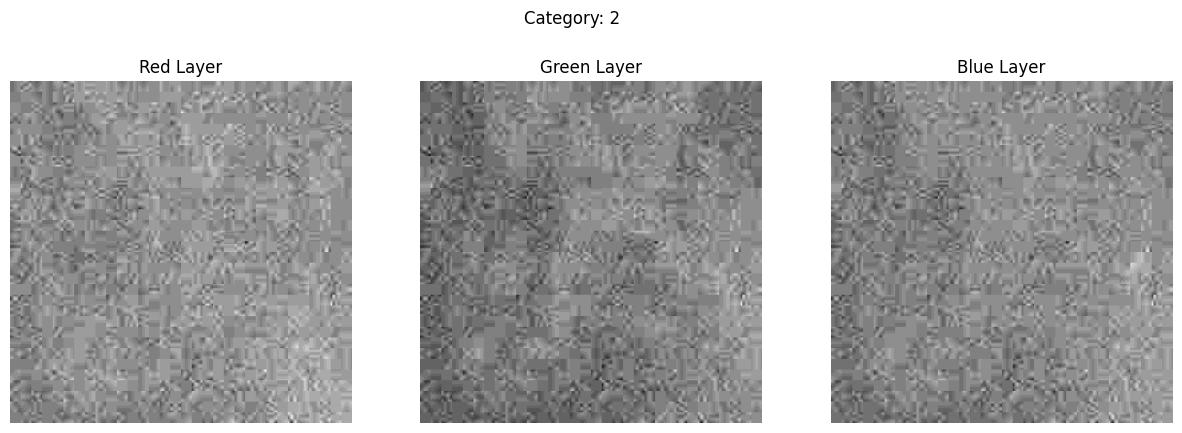

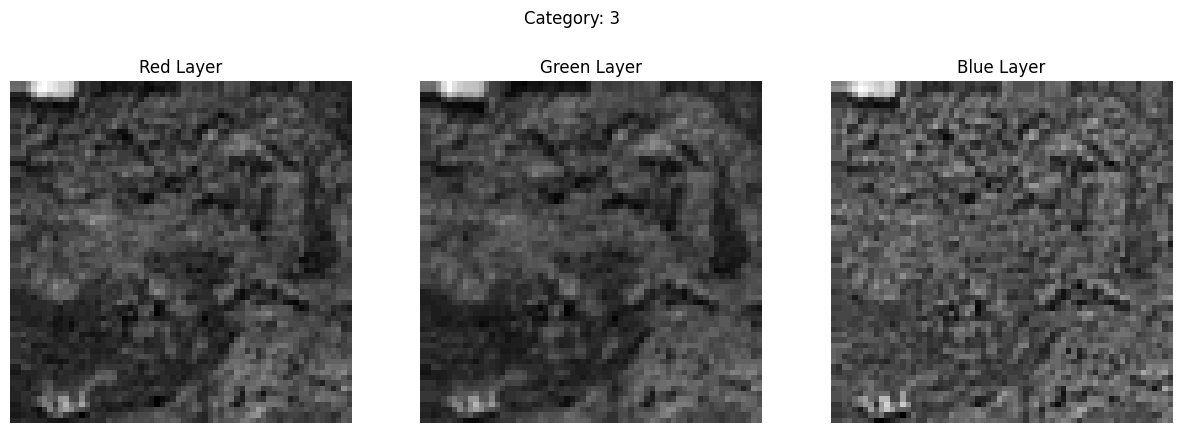

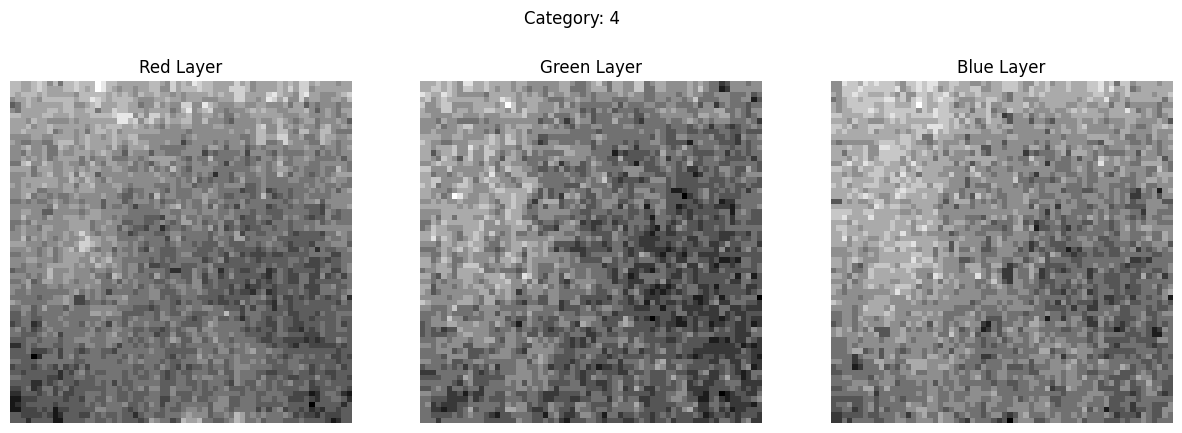

In [ ]:
# Display the RGB layers for each image category
for cat in sorted(df['Category'].unique()):
    # Get the name of the first image in the category
    sample_image = df[df['Category'] == cat].iloc[0]['Image_Name']

    # Load the image
    image_path = os.path.join(image_dir, sample_image)
    image = imread(image_path)

    # Create a figure for RGB layers
    plt.figure(figsize=(15, 5))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i + 1)
        plt.title(f'{color} Layer')
        plt.imshow(image[:, :, i], cmap='gray')
        plt.axis('off')  # Hide axes for better visualization
    plt.suptitle(f'Category: {cat}')
    plt.show()

Category: 1


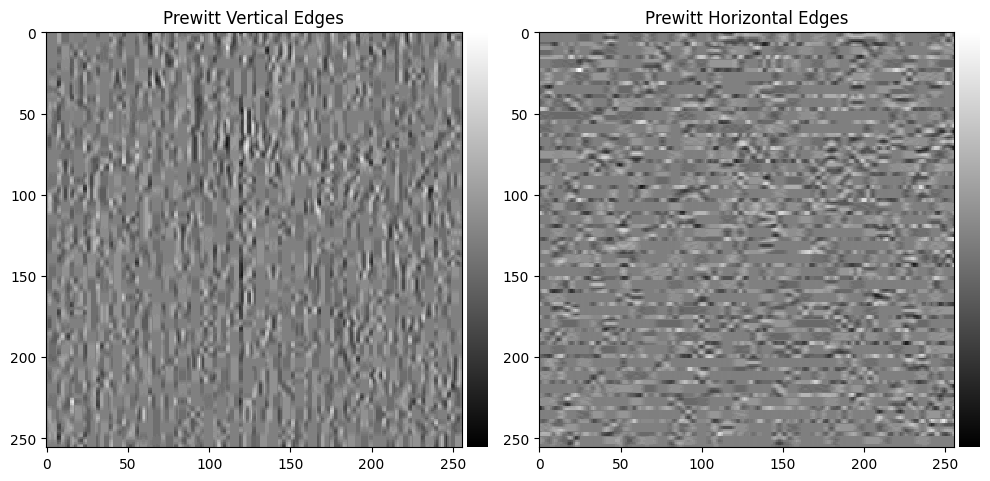

Category: 2


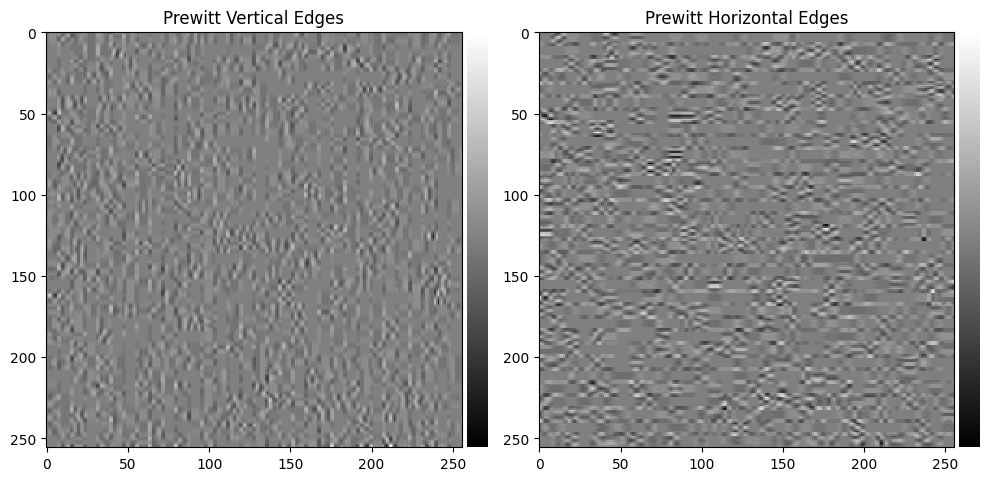

Category: 3


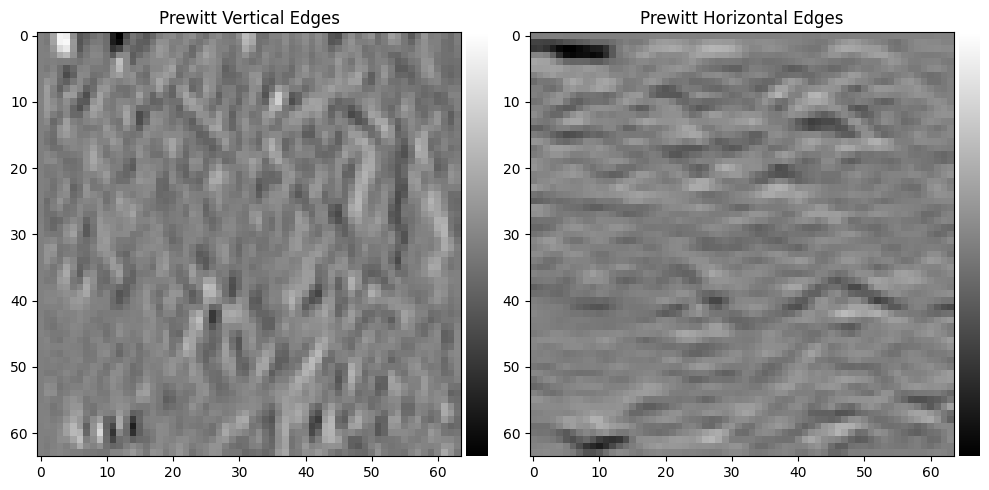

Category: 4


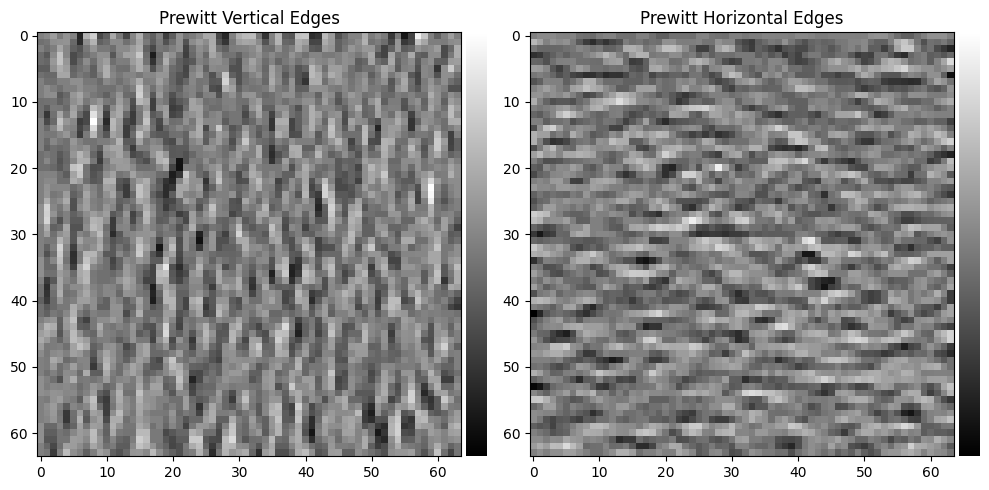

In [ ]:
# Iterate over each unique category in the dataframe
for cat in sorted(df['Category'].unique()):
    # Get the name of the first image in the category
    sample_image = df[df['Category'] == cat].iloc[0]['Image_Name']

    # Construct the path to the image and load it
    image_path = os.path.join(image_dir, sample_image)
    image = imread(image_path)

    # Convert the loaded image to grayscale using the mean pixel value across color channels
    feature_matrix = image.mean(axis=2)

    # Directly load the image as a grayscale image
    image_gray = imread(image_path, as_gray=True)

    # Apply Prewitt filters to detect edges
    edges_prewitt_horizontal = prewitt_h(image_gray)
    edges_prewitt_vertical = prewitt_v(image_gray)

    print(f'Category: {cat}')

    # Display the results
    plt.figure(figsize=(10, 5))

    # Display Prewitt Vertical Edges
    plt.subplot(1,2,1)
    plt.title('Prewitt Vertical Edges')
    imshow (edges_prewitt_vertical, cmap='gray')
    plt.axis('off')

    # Display Prewitt Horizontal Edges
    plt.subplot(1,2,2)
    plt.title('Prewitt Horizontal Edges')
    imshow (edges_prewitt_horizontal, cmap='gray')
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

## **3. Feature Extraction**

In [ ]:
# Process each category set for feature extraction and classification
# Get list of image names for the category
image_list = df['Image_Name'].tolist()

# Parameters for Local Binary Pattern (LBP) feature extraction
METHOD = 'uniform'
radius = 1
n_points = 8 * radius

all_features = []  # List to hold all extracted features

# Loop through each image, extract features, and store them
for image_name in image_list:
    image_path = os.path.join(image_dir, image_name)
    image = imread(image_path)  # Read the image
    image = resize(image, (100, 100))  # Resize image to 100x100 pixels

    # Extract RGB features by averaging the pixel values
    rgb_feature_matrix = np.mean(image, axis=2)
    rgb_features = rgb_feature_matrix.flatten()  # Flatten to 1D array

    # Convert image to grayscale for further feature extraction
    gray_image = rgb2gray(image)

    # Extract Local Binary Pattern features
    lbp_image = local_binary_pattern(gray_image, n_points, radius, METHOD)
    lbp_features = lbp_image.flatten()

    # Extract horizontal and vertical edge features using Prewitt filters
    horizontal_edges = prewitt_h(gray_image).flatten()
    vertical_edges = prewitt_v(gray_image).flatten()

    # Combine all features into a single array
    features = np.concatenate([rgb_features, lbp_features, horizontal_edges, vertical_edges])
    all_features.append(features)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


## **4. Separating Features and Labels**

In [ ]:
# Convert the list of features to a NumPy array
X = np.array(all_features)
y = df['Category'].values  # Labels for each image

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## **5. Standardize the features**

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## **6. Defining the Classifiers**

In [ ]:
# Define classifiers to use
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Gaussian NB': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=100, solver='lbfgs', multi_class='auto'),
    'SVM Linear': svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', probability=True),
    'SVM RBF': svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo', probability=True),
    'SVM Polynomial': svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo', probability=True),
    'SVM Sigmoid': svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo', probability=True)
}

## **7. Performing 5-Fold Cross Validation**

In [ ]:
# Initialize lists to store classifier names and their corresponding cross-validation accuracies
classifier_names = []
cv_accuracies = []

In [ ]:
# Train each classifier and evaluate using cross-validation
for name, clf in classifiers.items():
    # Fit the model to the training data
    clf.fit(X_train, y_train)
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv)
    mean_score = np.mean(scores)
    classifier_names.append(name)
    cv_accuracies.append(mean_score * 100)
    print(f'{name} CV Accuracy: {round(mean_score * 100, 2)} ± {round(np.std(scores) * 100, 2)}')

Decision Tree CV Accuracy: 70.52 ± 5.28
KNN CV Accuracy: 48.79 ± 2.75
Gaussian NB CV Accuracy: 71.33 ± 3.32
Random Forest CV Accuracy: 88.63 ± 3.29


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression CV Accuracy: 80.88 ± 3.04
SVM Linear CV Accuracy: 82.49 ± 3.64
SVM RBF CV Accuracy: 25.55 ± 2.75
SVM Polynomial CV Accuracy: 53.12 ± 4.73
SVM Sigmoid CV Accuracy: 61.37 ± 1.98


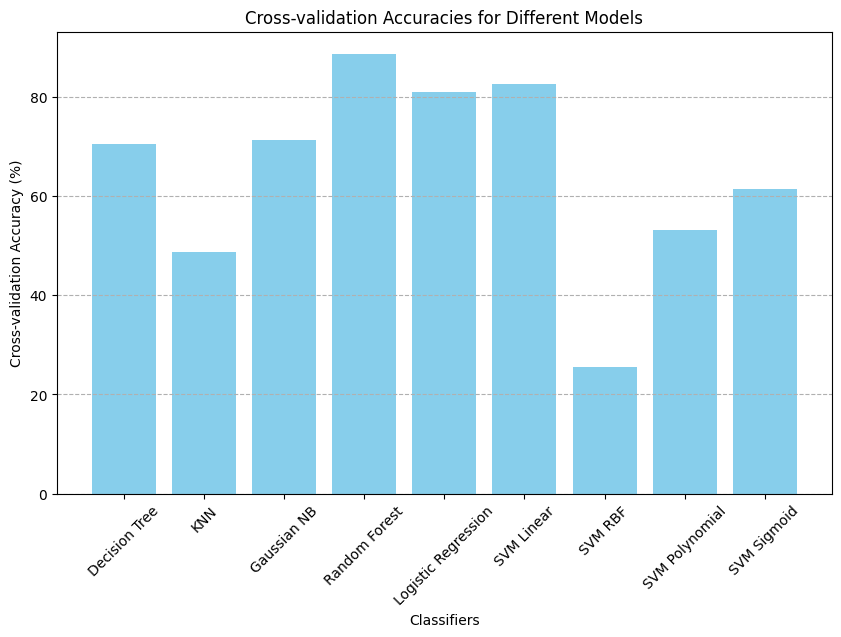

In [ ]:
# Plotting cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.bar(classifier_names, cv_accuracies, color='skyblue')
plt.xlabel('Classifiers')
plt.ylabel('Cross-validation Accuracy (%)')
plt.title('Cross-validation Accuracies for Different Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

## **8. Evaluating the Models**



In [ ]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Re-fit the model on the full training set
    # Predict on test set and print classification report
    y_pred = clf.predict(X_test)
    print(f'Classification Report for {name}')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy Score: {round(accuracy_score(y_test, y_pred) * 100, 2)}\n')

Classification Report for Decision Tree
              precision    recall  f1-score   support

           1       0.57      0.65      0.61       106
           2       0.63      0.52      0.57       100
           3       0.79      0.83      0.81       103
           4       0.82      0.80      0.81       118

    accuracy                           0.70       427
   macro avg       0.70      0.70      0.70       427
weighted avg       0.71      0.70      0.70       427

Accuracy Score: 70.49

Classification Report for KNN
              precision    recall  f1-score   support

           1       0.48      0.81      0.60       106
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       103
           4       0.47      0.99      0.64       118

    accuracy                           0.48       427
   macro avg       0.24      0.45      0.31       427
weighted avg       0.25      0.48      0.33       427

Accuracy Score: 47.54



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Gaussian NB
              precision    recall  f1-score   support

           1       0.60      0.41      0.48       106
           2       0.57      0.82      0.67       100
           3       0.78      0.96      0.86       103
           4       0.94      0.68      0.79       118

    accuracy                           0.71       427
   macro avg       0.72      0.72      0.70       427
weighted avg       0.73      0.71      0.70       427

Accuracy Score: 71.19

Classification Report for Random Forest
              precision    recall  f1-score   support

           1       0.74      0.83      0.78       106
           2       0.87      0.74      0.80       100
           3       0.96      0.99      0.98       103
           4       0.95      0.94      0.94       118

    accuracy                           0.88       427
   macro avg       0.88      0.88      0.88       427
weighted avg       0.88      0.88      0.88       427

Accuracy Score: 87.82



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           1       0.65      0.84      0.74       106
           2       0.86      0.60      0.71       100
           3       0.86      0.88      0.87       103
           4       0.84      0.82      0.83       118

    accuracy                           0.79       427
   macro avg       0.80      0.79      0.79       427
weighted avg       0.80      0.79      0.79       427

Accuracy Score: 78.92

Classification Report for SVM Linear
              precision    recall  f1-score   support

           1       0.69      0.87      0.77       106
           2       0.95      0.62      0.75       100
           3       0.95      0.91      0.93       103
           4       0.86      0.95      0.90       118

    accuracy                           0.84       427
   macro avg       0.86      0.84      0.84       427
weighted avg       0.86      0.84      0.84       427

Accuracy Score: 84.31

C

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SVM Polynomial
              precision    recall  f1-score   support

           1       0.43      0.93      0.59       106
           2       0.00      0.00      0.00       100
           3       0.53      0.98      0.69       103
           4       0.00      0.00      0.00       118

    accuracy                           0.47       427
   macro avg       0.24      0.48      0.32       427
weighted avg       0.24      0.47      0.31       427

Accuracy Score: 46.84

Classification Report for SVM Sigmoid
              precision    recall  f1-score   support

           1       0.57      0.83      0.67       106
           2       0.78      0.39      0.52       100
           3       0.63      0.96      0.76       103
           4       0.86      0.47      0.61       118

    accuracy                           0.66       427
   macro avg       0.71      0.66      0.64       427
weighted avg       0.71      0.66      0.64       427

Accuracy Score: 66.04



In [ ]:
# Save the Random Forest model
rf_model = classifiers['Random Forest']
rf_model_filename = 'satellite_image_rf_model.pkl'
with open(rf_model_filename, 'wb') as model_file:
  pickle.dump(rf_model, model_file)

# Save the Linear SVM model
linear_model = classifiers['SVM Linear']
linear_model_filename = 'satellite_image_linear_model.pkl'
with open(linear_model_filename, 'wb') as model_file:
  pickle.dump(linear_model, model_file)

# Save the Logistic Regression model
lr_model = classifiers['Logistic Regression']
lr_model_filename = 'satellite_image_lr_model.pkl'
with open(lr_model_filename, 'wb') as model_file:
  pickle.dump(lr_model, model_file)

# Save the scaler
scaler_filename = 'satellite_image_scaler.pkl'
scaler = sc
with open(scaler_filename, 'wb') as scaler_file:
  pickle.dump(scaler, scaler_file)

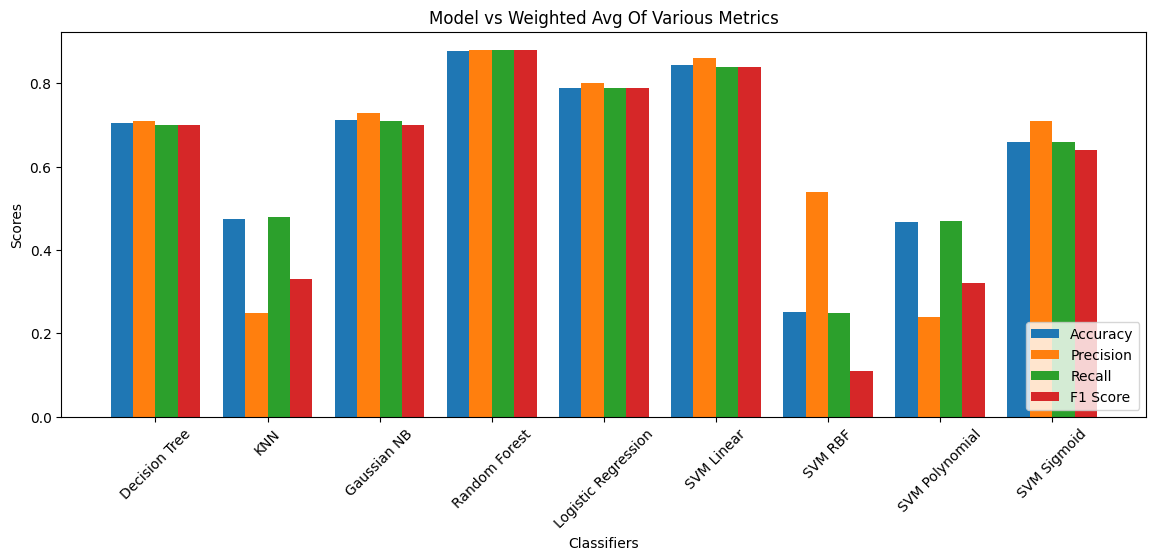

In [ ]:
# Accuracy scores for each classifier
accuracy_list = [0.7049, 0.4754, 0.7119, 0.8782, 0.7892, 0.8431, 0.2506, 0.4684, 0.6604]

# Wighted average precision for each classifier
precision_list = [0.71, 0.25, 0.73, 0.88, 0.80, 0.86, 0.54, 0.24, 0.71]

# Wighted average recall for each classifier
recall_list = [0.70, 0.48, 0.71, 0.88, 0.79, 0.84, 0.25, 0.47, 0.66]

# Weighted average F1 scores for each classifier
f1_list = [0.70, 0.33, 0.70, 0.88, 0.79, 0.84, 0.11, 0.31, 0.64]

# Classifier names
classifier_names = [
    'Decision Tree', 'KNN', 'Gaussian NB', 'Random Forest',
    'Logistic Regression', 'SVM Linear', 'SVM RBF',
    'SVM Polynomial', 'SVM Sigmoid'
]

# Plot the accuracy and weighted average precision, recall, and F1 scores
plt.figure(figsize=(14, 5))
x = np.arange(len(classifier_names))
plt.bar(x - 0.3, accuracy_list, 0.2, label='Accuracy')
plt.bar(x - 0.1, precision_list, 0.2, label='Precision')
plt.bar(x + 0.1, recall_list, 0.2, label='Recall')
plt.bar(x + 0.3, f1_list, 0.2, label='F1 Score')

plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.title('Model vs Weighted Avg Of Various Metrics')
plt.xticks(x, classifier_names, rotation=45)
plt.legend(loc='lower right')
plt.show()

## **9. Clustering with KMeans**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

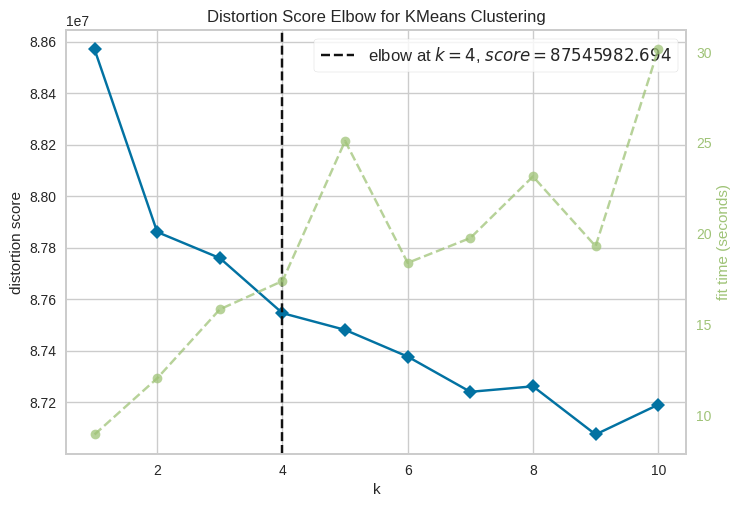

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(X) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()